# Лабораторная работа №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнила: Глебова Мария Алексеевна
###### Группа: М8О-307Б-23
###### Датасет: [Факторы успеваемости студентов](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors)

---


# Задание:

0. Выбрать модель для обучения (Decision tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и в зависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).


## 0. Выбор модели

**Выбранная модель: Random Forest (Случайный лес)**

Random Forest выбран по следующим причинам:
- Хорошо работает как для классификации, так и для регрессии
- Устойчив к переобучению
- Может обрабатывать категориальные и числовые признаки
- Имеет множество гиперпараметров для настройки
- Позволяет оценивать важность признаков


## 1. Гиперпараметры Random Forest

Ниже представлена таблица основных гиперпараметров модели Random Forest:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import optuna
import warnings
warnings.filterwarnings('ignore')

# Для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Создаем таблицу гиперпараметров Random Forest
hyperparams_table = pd.DataFrame({
    'Гиперпараметр': [
        'n_estimators',
        'max_depth',
        'min_samples_split',
        'min_samples_leaf',
        'max_features',
        'criterion',
        'bootstrap',
        'max_samples',
        'class_weight',
        'random_state',
        'n_jobs'
    ],
    'Описание': [
        'Количество деревьев в лесу',
        'Максимальная глубина дерева (None = без ограничений)',
        'Минимальное количество образцов для разделения узла',
        'Минимальное количество образцов в листе',
        'Количество признаков для рассмотрения при разделении (sqrt, log2, None или число)',
        'Функция для измерения качества разделения (gini, entropy, log_loss)',
        'Использовать ли bootstrap выборку при построении деревьев',
        'Количество образцов для обучения каждого дерева (если bootstrap=True)',
        'Веса классов (для несбалансированных данных)',
        'Случайное состояние для воспроизводимости',
        'Количество параллельных задач (-1 = все доступные ядра)'
    ],
    'Тип': [
        'int',
        'int или None',
        'int или float',
        'int или float',
        'str, int, float или None',
        'str',
        'bool',
        'int, float или None',
        'dict, list или str',
        'int',
        'int'
    ],
    'Значение по умолчанию': [
        '100',
        'None',
        '2',
        '1',
        'sqrt',
        'gini',
        'True',
        'None',
        'None',
        'None',
        'None'
    ]
})

print("Таблица гиперпараметров Random Forest:")
print("=" * 100)
display(hyperparams_table)


Таблица гиперпараметров Random Forest:


,Гиперпараметр,Описание,Тип,Значение по умолчанию
0,n_estimators,Количество деревьев в лесу,int,100
1,max_depth,Максимальная глубина дерева (None = без ограни...,int или None,None
2,min_samples_split,Минимальное количество образцов для разделения...,int или float,2
3,min_samples_leaf,Минимальное количество образцов в листе,int или float,1
4,max_features,Количество признаков для рассмотрения при разд...,"str, int, float или None",sqrt
5,criterion,Функция для измерения качества разделения (gin...,str,gini
6,bootstrap,Использовать ли bootstrap выборку при построен...,bool,True
7,max_samples,Количество образцов для обучения каждого дерев...,"int, float или None",None
8,class_weight,Веса классов (для несбалансированных данных),"dict, list или str",None
9,random_state,Случайное состояние для воспроизводимости,int,None


## 2. Загрузка и подготовка данных

### 2.1. Загрузка датасета


In [ ]:
# Загрузка датасета
# Инструкция по загрузке:
# 1. Установите kaggle API: pip install kaggle
# 2. Загрузите датасет: !kaggle datasets download -d lainguyn123/student-performance-factors
# 3. Распакуйте: !unzip student-performance-factors.zip
# ИЛИ загрузите файл вручную в папку с ноутбуком

import os

# Попробуем найти датасет
df = None
possible_names = [
    'student_performance_factors.csv',
    'student-performance-factors.csv',
    'student.csv',
    'data.csv',
    'dataset.csv'
]

# Ищем в текущей директории и в родительской
search_paths = ['.', '..', '../..']
for path in search_paths:
    for name in possible_names:
        file_path = os.path.join(path, name)
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                print(f"✅ Датасет загружен из: {file_path}")
                break
            except Exception as e:
                continue
    if df is not None:
        break

# Если не нашли, ищем любой CSV файл
if df is None:
    for path in search_paths:
        try:
            files = [f for f in os.listdir(path) if f.endswith('.csv')]
            if files:
                df = pd.read_csv(os.path.join(path, files[0]))
                print(f"✅ Датасет загружен из: {os.path.join(path, files[0])}")
                break
        except:
            continue

if df is None:
    print("⚠️ Файл не найден. Пожалуйста, загрузите датасет вручную.")
    print("Ссылка на датасет: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors")
    print("\nДля загрузки через Kaggle API выполните:")
    print("  !pip install kaggle")
    print("  !kaggle datasets download -d lainguyn123/student-performance-factors")
    print("  !unzip student-performance-factors.zip")
else:
    print(f"\n📊 Размер датасета: {df.shape[0]} строк, {df.shape[1]} признаков")
    print(f"\n📋 Первые строки:")
    display(df.head(10))
    print(f"\n📝 Информация о датасете:")
    print(df.info())
    print(f"\n📈 Описательная статистика:")
    display(df.describe())


✅ Датасет загружен из: .\StudentPerformanceFactors.csv

📊 Размер датасета: 6607 строк, 20 признаков

📋 Первые строки:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
5,19,88,Medium,Medium,Yes,8,89,Medium,Yes,3,Medium,Medium,Public,Positive,3,No,Postgraduate,Near,Male,71
6,29,84,Medium,Low,Yes,7,68,Low,Yes,1,Low,Medium,Private,Neutral,2,No,High School,Moderate,Male,67
7,25,78,Low,High,Yes,6,50,Medium,Yes,1,High,High,Public,Negative,2,No,High School,Far,Male,66
8,17,94,Medium,High,No,6,80,High,Yes,0,Medium,Low,Private,Neutral,1,No,College,Near,Male,69
9,23,98,Medium,Medium,Yes,8,71,Medium,Yes,0,High,High,Public,Positive,5,No,High School,Moderate,Male,72



📝 Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence        

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


### 2.2. Исследовательский анализ данных (EDA)


In [ ]:
if df is not None:
    # Проверка на пропуски
    print("Пропущенные значения:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    # Проверка дубликатов
    print(f"\nКоличество дубликатов: {df.duplicated().sum()}")
    
    # Распределение целевой переменной (если она есть)
    # Нужно определить целевую переменную на основе датасета
    print("\nКолонки датасета:")
    print(df.columns.tolist())


Пропущенные значения:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64

Количество дубликатов: 0

Колонки датасета:
['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']


### 2.3. Подготовка данных для обучения

**Задача:** Классификация успеваемости студентов

Определим целевую переменную и признаки на основе структуры датасета.


In [ ]:
if df is not None:
    # Сохраняем копию исходных данных
    df_original = df.copy()
    
    # Предобработка данных
    print("=" * 80)
    print("ПРЕДОБРАБОТКА ДАННЫХ")
    print("=" * 80)
    
    # Проверка пропусков
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\n⚠️ Пропущенные значения:")
        print(missing[missing > 0])
        # Заполняем пропуски медианой для числовых и модой для категориальных
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['int64', 'float64']:
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)
        print("✅ Пропуски заполнены")
    else:
        print("\n✅ Пропущенных значений нет")
    
    # Кодирование категориальных переменных
    le_dict = {}
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        print(f"\n📝 Найдено категориальных признаков: {len(categorical_cols)}")
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le
        print("✅ Категориальные признаки закодированы")
    else:
        print("\n✅ Категориальных признаков нет")
    
    # Определение целевой переменной
    print("\n" + "=" * 80)
    print("ОПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
    print("=" * 80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\n📊 Числовые колонки ({len(numeric_cols)}):")
    print(numeric_cols)
    
    # Ищем возможные целевые переменные
    possible_targets = []
    keywords = ['grade', 'score', 'performance', 'result', 'target', 'y', 'g3', 'g2', 'g1', 
                'final', 'total', 'average', 'mean', 'mark', 'rating']
    
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in keywords):
            possible_targets.append(col)
    
    print(f"\n🎯 Возможные целевые переменные:")
    if possible_targets:
        for target in possible_targets:
            print(f"  - {target}: {df[target].dtype}, уникальных значений: {df[target].nunique()}")
            if df[target].dtype in ['int64', 'float64']:
                print(f"    Диапазон: [{df[target].min()}, {df[target].max()}]")
    else:
        print("  Не найдено. Будем использовать последнюю числовую колонку или создадим целевую переменную.")
    
    # Автоматический выбор целевой переменной
    if possible_targets:
        # Предпочитаем колонки с 'g3', 'final', 'total', 'score'
        priority_keywords = ['g3', 'final', 'total', 'score']
        target_col = None
        for keyword in priority_keywords:
            for col in possible_targets:
                if keyword in col.lower():
                    target_col = col
                    break
            if target_col:
                break
        if not target_col:
            target_col = possible_targets[0]
    else:
        # Используем последнюю числовую колонку
        target_col = numeric_cols[-1] if numeric_cols else None
    
    if target_col:
        print(f"\n✅ Выбрана целевая переменная: {target_col}")
        
        # Создаем целевую переменную для классификации
        y_raw = df[target_col].copy()
        
        # Если значений много, создаем категории
        if y_raw.nunique() > 10:
            # Создаем 3 категории: Низкая, Средняя, Высокая
            y = pd.cut(y_raw, bins=3, labels=['Низкая', 'Средняя', 'Высокая'])
            class_names = ['Низкая успеваемость', 'Средняя успеваемость', 'Высокая успеваемость']
            print(f"   Созданы 3 категории успеваемости")
        else:
            # Используем как есть
            y = y_raw
            class_names = [f'Класс {i}' for i in range(y.nunique())]
            print(f"   Используется {y.nunique()} классов")
        
        # Кодируем целевую переменную
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        
        # Признаки
        X = df.drop(target_col, axis=1)
        
        print(f"\n📊 Итоговая структура:")
        print(f"   Признаков (X): {X.shape[1]}")
        print(f"   Примеров: {X.shape[0]}")
        print(f"   Классов: {len(np.unique(y_encoded))}")
        print(f"   Распределение классов:")
        unique, counts = np.unique(y_encoded, return_counts=True)
        for u, c in zip(unique, counts):
            class_label = class_names[u] if u < len(class_names) else f'Класс {u}'
            print(f"     {class_label}: {c} ({c/len(y_encoded)*100:.1f}%)")
    else:
        print("\n❌ Не удалось определить целевую переменную. Проверьте структуру датасета.")
        X, y_encoded, class_names = None, None, None


ПРЕДОБРАБОТКА ДАННЫХ

⚠️ Пропущенные значения:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64
✅ Пропуски заполнены

📝 Найдено категориальных признаков: 13
✅ Категориальные признаки закодированы

ОПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

📊 Числовые колонки (20):
['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

🎯 Возможные целевые переменные:
  - Previous_Scores: int64, уникальных значений: 51
    Диапазон: [50, 100]
  - Family_Income: int32, уникальных значений: 3
  - Teacher_Quality: int32, уникальных значений: 3
  - School_Type: int32, уникальных значений: 2
  - Physical_Activity: int64, уникальных 

## 3. Подбор гиперпараметров

Будем использовать три метода:
1. **Grid Search** - полный перебор всех комбинаций
2. **Random Search** - случайный поиск
3. **Optuna** - байесовская оптимизация

### 3.1. Разделение данных на train/test


In [ ]:
if df is not None and X is not None and y_encoded is not None:
    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, 
        test_size=0.2, 
        random_state=RANDOM_STATE, 
        stratify=y_encoded
    )
    
    print("=" * 80)
    print("РАЗДЕЛЕНИЕ ДАННЫХ")
    print("=" * 80)
    print(f"✅ Обучающая выборка: {X_train.shape[0]} примеров ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"✅ Тестовая выборка: {X_test.shape[0]} примеров ({X_test.shape[0]/len(X)*100:.1f}%)")
    print(f"✅ Количество признаков: {X_train.shape[1]}")
    
    # Проверяем распределение классов
    print(f"\n📊 Распределение классов в обучающей выборке:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    for u, c in zip(unique_train, counts_train):
        class_label = class_names[u] if u < len(class_names) else f'Класс {u}'
        print(f"   {class_label}: {c} ({c/len(y_train)*100:.1f}%)")
else:
    print("⚠️ Данные не подготовлены. Пожалуйста, выполните предыдущие ячейки.")


РАЗДЕЛЕНИЕ ДАННЫХ
✅ Обучающая выборка: 5285 примеров (80.0%)
✅ Тестовая выборка: 1322 примеров (20.0%)
✅ Количество признаков: 19

📊 Распределение классов в обучающей выборке:
   Низкая успеваемость: 1753 (33.2%)
   Средняя успеваемость: 1737 (32.9%)
   Высокая успеваемость: 1795 (34.0%)


### 3.1. Создание пайплайна


In [ ]:
# Создаем пайплайн с масштабированием и моделью
# Примечание: Random Forest не требует масштабирования, но добавим для единообразия
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # масштабирование (опционально для RF)
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))  # модель
])

print("✅ Пайплайн создан:")
print(pipeline)
print("\n📝 Структура пайплайна:")
print("   1. StandardScaler - масштабирование признаков")
print("   2. RandomForestClassifier - классификатор")


✅ Пайплайн создан:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

📝 Структура пайплайна:
   1. StandardScaler - масштабирование признаков
   2. RandomForestClassifier - классификатор


### 3.2. Grid Search


In [8]:
# Параметры для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Параметры для Grid Search:")
for key, value in param_grid.items():
    print(f"  {key}: {value}")

# Подсчет общего количества комбинаций
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nВсего комбинаций для перебора: {total_combinations}")


Параметры для Grid Search:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Всего комбинаций для перебора: 324


In [ ]:
# Grid Search
if 'X_train' in globals() and X_train is not None:
    print("=" * 80)
    print("GRID SEARCH - НАЧАЛО ОПТИМИЗАЦИИ")
    print("=" * 80)
    print(f"⏳ Перебираем {total_combinations} комбинаций параметров...")
    print("Это может занять некоторое время...\n")
    
    import time
    start_time = time.time()
    
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    grid_search_time = time.time() - start_time
    
    print("\n" + "=" * 80)
    print("GRID SEARCH - РЕЗУЛЬТАТЫ")
    print("=" * 80)
    print("\n✅ Лучшие параметры:")
    for key, value in grid_search.best_params_.items():
        print(f"   {key}: {value}")
    print(f"\n📊 Лучший score на кросс-валидации: {grid_search.best_score_:.4f}")
    print(f"📊 Точность на тесте: {grid_search.score(X_test, y_test):.4f}")
    print(f"⏱️ Время выполнения: {grid_search_time:.2f} секунд ({grid_search_time/60:.2f} минут)")
    
    # Сохраняем лучшую модель
    best_model_grid = grid_search.best_estimator_
else:
    print("⚠️ Данные не подготовлены. Пожалуйста, выполните предыдущие ячейки.")


GRID SEARCH - НАЧАЛО ОПТИМИЗАЦИИ
⏳ Перебираем 324 комбинаций параметров...
Это может занять некоторое время...

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

GRID SEARCH - РЕЗУЛЬТАТЫ

✅ Лучшие параметры:
   max_depth: None
   max_features: None
   min_samples_leaf: 2
   min_samples_split: 10
   n_estimators: 200

📊 Лучший score на кросс-валидации: 0.4666
📊 Точность на тесте: 0.4667
⏱️ Время выполнения: 515.58 секунд (8.59 минут)


### 3.3. Random Search


In [ ]:
# Параметры для Random Search (более широкий диапазон)
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None]
}

print("Параметры для Random Search:")
for key, value in param_distributions.items():
    print(f"  {key}: {value}")

# Random Search
if 'X_train' in globals() and X_train is not None:
    print("\n" + "=" * 80)
    print("RANDOM SEARCH - НАЧАЛО ОПТИМИЗАЦИИ")
    print("=" * 80)
    print("⏳ Выполняем случайный поиск по 50 комбинациям...")
    print("Это может занять некоторое время...\n")
    
    import time
    start_time = time.time()
    
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=50,  # количество случайных комбинаций
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        return_train_score=True
    )
    
    random_search.fit(X_train, y_train)
    
    random_search_time = time.time() - start_time
    
    print("\n" + "=" * 80)
    print("RANDOM SEARCH - РЕЗУЛЬТАТЫ")
    print("=" * 80)
    print("\n✅ Лучшие параметры:")
    for key, value in random_search.best_params_.items():
        print(f"   {key}: {value}")
    print(f"\n📊 Лучший score на кросс-валидации: {random_search.best_score_:.4f}")
    print(f"📊 Точность на тесте: {random_search.score(X_test, y_test):.4f}")
    print(f"⏱️ Время выполнения: {random_search_time:.2f} секунд ({random_search_time/60:.2f} минут)")
    
    # Сохраняем лучшую модель
    best_model_random = random_search.best_estimator_
else:
    print("⚠️ Данные не подготовлены. Пожалуйста, выполните предыдущие ячейки.")


Параметры для Random Search:
  n_estimators: [50, 100, 150, 200, 250, 300]
  max_depth: [3, 5, 7, 10, 15, 20, None]
  min_samples_split: [2, 5, 10, 15, 20]
  min_samples_leaf: [1, 2, 4, 6, 8]
  max_features: ['sqrt', 'log2', None]

RANDOM SEARCH - НАЧАЛО ОПТИМИЗАЦИИ
⏳ Выполняем случайный поиск по 50 комбинациям...
Это может занять некоторое время...

Fitting 5 folds for each of 50 candidates, totalling 250 fits

RANDOM SEARCH - РЕЗУЛЬТАТЫ

✅ Лучшие параметры:
   n_estimators: 250
   min_samples_split: 10
   min_samples_leaf: 1
   max_features: None
   max_depth: 10

📊 Лучший score на кросс-валидации: 0.4621
📊 Точность на тесте: 0.4523
⏱️ Время выполнения: 101.69 секунд (1.69 минут)


### 3.4. Optuna (Байесовская оптимизация)


In [11]:
# Установка Optuna (если не установлена)
# !pip install optuna
try:
    import optuna
except ImportError:
    print("⚠️ Optuna не установлена. Выполните: !pip install optuna")
    print("   Затем перезапустите эту ячейку.")

from sklearn.model_selection import cross_val_score

# Функция для оптимизации Optuna
def objective_optuna(trial):
    """
    Функция для оптимизации гиперпараметров с помощью Optuna
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    # Создаем модель с предложенными параметрами
    model = RandomForestClassifier(**params)
    
    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

print("✅ Функция для Optuna создана")
if 'X_train' in globals() and X_train is not None:
    print("✅ Готов к оптимизации (100 trials)")
else:
    print("⚠️ Оптимизация будет выполнена после загрузки данных")


✅ Функция для Optuna создана
✅ Готов к оптимизации (100 trials)


In [12]:
# Optuna оптимизация
if 'X_train' in globals() and X_train is not None:
    print("\n" + "=" * 80)
    print("OPTUNA - НАЧАЛО ОПТИМИЗАЦИИ")
    print("=" * 80)
    print("⏳ Выполняем байесовскую оптимизацию (100 trials)...")
    print("Это может занять некоторое время...\n")
    
    import time
    start_time = time.time()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_optuna, n_trials=100, n_jobs=1, show_progress_bar=True)
    
    optuna_time = time.time() - start_time
    
    print("\n" + "=" * 80)
    print("OPTUNA - РЕЗУЛЬТАТЫ")
    print("=" * 80)
    print("\n✅ Лучшие параметры:")
    for key, value in study.best_params.items():
        print(f"   {key}: {value}")
    print(f"\n📊 Лучший score на кросс-валидации: {study.best_value:.4f}")
    
    # Обучаем модель с лучшими параметрами
    best_model_optuna = RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE, n_jobs=-1)
    best_model_optuna.fit(X_train, y_train)
    optuna_test_score = best_model_optuna.score(X_test, y_test)
    print(f"📊 Точность на тесте: {optuna_test_score:.4f}")
    print(f"⏱️ Время выполнения: {optuna_time:.2f} секунд ({optuna_time/60:.2f} минут)")
else:
    print("⚠️ Данные не подготовлены. Пожалуйста, выполните предыдущие ячейки.")


[I 2025-11-13 01:55:10,714] A new study created in memory with name: no-name-39ba095d-4294-415f-b1cd-8b9bbe3e3407



OPTUNA - НАЧАЛО ОПТИМИЗАЦИИ
⏳ Выполняем байесовскую оптимизацию (100 trials)...
Это может занять некоторое время...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-13 01:55:11,307] Trial 0 finished with value: 0.43254493850520337 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.43254493850520337.
[I 2025-11-13 01:55:13,141] Trial 1 finished with value: 0.4264900662251656 and parameters: {'n_estimators': 292, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.43254493850520337.
[I 2025-11-13 01:55:14,723] Trial 2 finished with value: 0.45581835383159885 and parameters: {'n_estimators': 70, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 0.45581835383159885.
[I 2025-11-13 01:55:15,090] Trial 3 finished with value: 0.4210028382213813 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.455818353831598

### 3.5. Сравнение результатов

После выполнения всех трех методов подбора гиперпараметров, сравним результаты.


СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ

📊 Сравнительная таблица:


,Метод,CV Score,Test Score,Время (сек)
0,Grid Search,0.466604,0.466717,515.581416
1,Random Search,0.462062,0.452345,101.691632
2,Optuna,0.466036,0.455371,340.567394



🏆 Лучший метод по точности на тесте: Grid Search
   Test Score: 0.4667


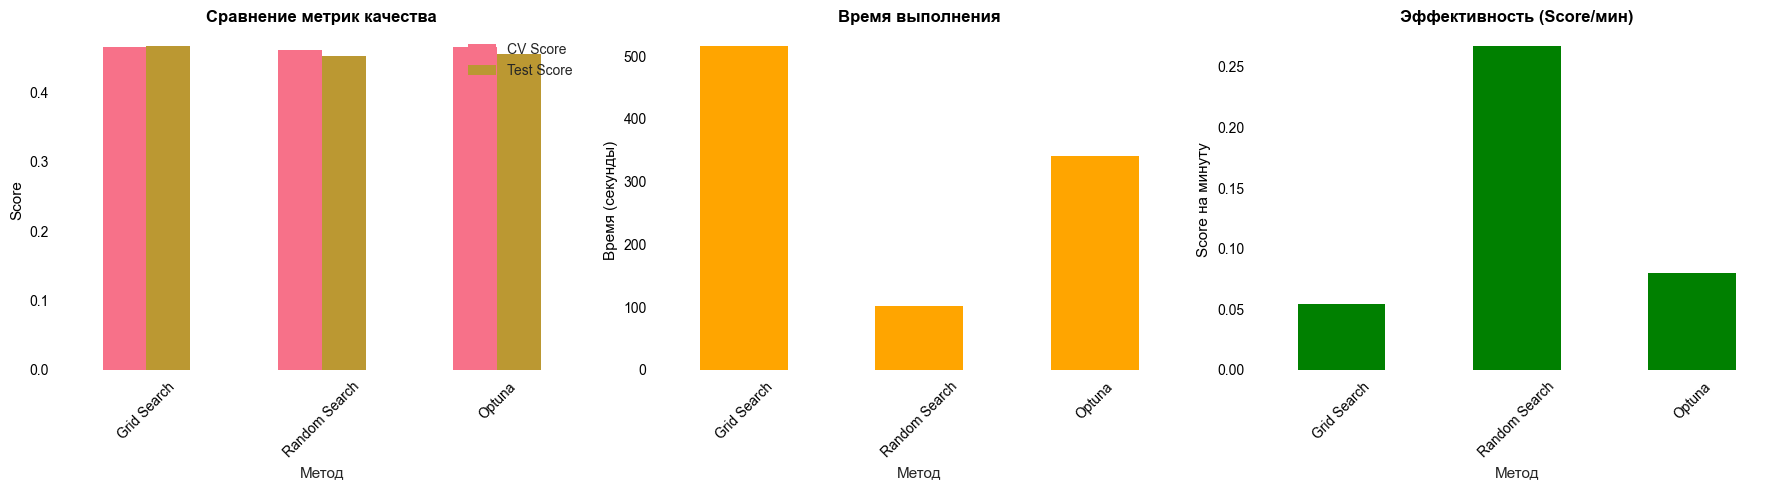


✅ Лучшая модель сохранена в переменной 'best_model'


In [13]:
# Сравнение результатов
if all(var in globals() for var in ['grid_search', 'random_search', 'study']):
    print("=" * 80)
    print("СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
    print("=" * 80)
    
    comparison_results = pd.DataFrame({
        'Метод': ['Grid Search', 'Random Search', 'Optuna'],
        'CV Score': [
            grid_search.best_score_,
            random_search.best_score_,
            study.best_value
        ],
        'Test Score': [
            grid_search.score(X_test, y_test),
            random_search.score(X_test, y_test),
            optuna_test_score
        ],
        'Время (сек)': [
            grid_search_time,
            random_search_time,
            optuna_time
        ]
    })
    
    print("\n📊 Сравнительная таблица:")
    display(comparison_results)
    
    # Определяем лучший метод
    best_method_idx = comparison_results['Test Score'].idxmax()
    best_method = comparison_results.loc[best_method_idx, 'Метод']
    print(f"\n🏆 Лучший метод по точности на тесте: {best_method}")
    print(f"   Test Score: {comparison_results.loc[best_method_idx, 'Test Score']:.4f}")
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.patch.set_facecolor('white')
    
    # Сравнение метрик качества
    comparison_results.set_index('Метод')[['CV Score', 'Test Score']].plot(kind='bar', ax=axes[0])
    axes[0].set_facecolor('white')
    axes[0].set_title('Сравнение метрик качества', fontsize=12, fontweight='bold', color='black')
    axes[0].set_ylabel('Score', color='black')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45, colors='black')
    axes[0].tick_params(axis='y', colors='black')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Время выполнения
    comparison_results.set_index('Метод')['Время (сек)'].plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_facecolor('white')
    axes[1].set_title('Время выполнения', fontsize=12, fontweight='bold', color='black')
    axes[1].set_ylabel('Время (секунды)', color='black')
    axes[1].tick_params(axis='x', rotation=45, colors='black')
    axes[1].tick_params(axis='y', colors='black')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Эффективность (Score / Время)
    comparison_results['Эффективность'] = comparison_results['Test Score'] / (comparison_results['Время (сек)'] / 60)
    comparison_results.set_index('Метод')['Эффективность'].plot(kind='bar', ax=axes[2], color='green')
    axes[2].set_facecolor('white')
    axes[2].set_title('Эффективность (Score/мин)', fontsize=12, fontweight='bold', color='black')
    axes[2].set_ylabel('Score на минуту', color='black')
    axes[2].tick_params(axis='x', rotation=45, colors='black')
    axes[2].tick_params(axis='y', colors='black')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Сохраняем лучшую модель
    if best_method == 'Grid Search':
        best_model = best_model_grid
    elif best_method == 'Random Search':
        best_model = best_model_random
    else:
        best_model = best_model_optuna
    
    print(f"\n✅ Лучшая модель сохранена в переменной 'best_model'")
else:
    print("⚠️ Не все методы оптимизации выполнены. Пожалуйста, выполните все предыдущие ячейки.")


## 4. Интерпретация модели с помощью LIME и SHAP

Для лучшей модели создадим калькулятор, который показывает:
- **Локальную интерпретацию** с помощью LIME
- **Глобальную интерпретацию** с помощью SHAP

### 4.1. Установка необходимых библиотек


In [14]:
# Попробуем установить, если не установлены
import subprocess
import sys

def install_package(package):
    """Установка пакета через pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        return True
    except:
        return False

# Проверяем и устанавливаем SHAP
try:
    import shap
    print("✅ SHAP уже установлен")
except ImportError:
    print("📦 Установка SHAP...")
    if install_package("shap"):
        import shap
        print("✅ SHAP успешно установлен")
    else:
        print("⚠️ Не удалось установить SHAP автоматически. Выполните вручную: !pip install shap")

# Проверяем и устанавливаем LIME
try:
    import lime
    import lime.lime_tabular
    print("✅ LIME уже установлен")
except ImportError:
    print("📦 Установка LIME...")
    # LIME может требовать дополнительные зависимости
    if install_package("lime"):
        try:
            import lime
            import lime.lime_tabular
            print("✅ LIME успешно установлен")
        except ImportError:
            print("⚠️ LIME установлен, но есть проблемы с импортом")
            print("   Попробуйте выполнить: !pip install lime --upgrade")
    else:
        print("⚠️ Не удалось установить LIME автоматически.")
        print("   Попробуйте выполнить вручную:")
        print("   !pip install lime")
        print("   или")
        print("   !pip install --upgrade pip")
        print("   !pip install lime")

print("\n✅ Проверка завершена")

✅ SHAP уже установлен
✅ LIME уже установлен

✅ Проверка завершена


### 4.2. Локальная интерпретация с LIME


LIME - ЛОКАЛЬНАЯ ИНТЕРПРЕТАЦИЯ
⏳ Создаем LIME объяснитель...
✅ LIME объяснитель создан

📊 Анализируем пример #1126 из тестовой выборки:
   Реальный класс: 0 (Низкая успеваемость)
   Предсказанный класс: 1 (Средняя успеваемость)
   Вероятности: [0.17843325 0.41673023 0.40483652]

⏳ Генерируем объяснение LIME...

📋 Таблица вклада признаков (Топ-15):
                                  Признак     Вклад
              80.00 < Attendance <= 90.00  0.079233
                Tutoring_Sessions <= 1.00 -0.034680
            Learning_Disabilities <= 0.00  0.034104
          1.00 < Motivation_Level <= 2.00  0.030198
             Parental_Involvement <= 0.00  0.024319
0.00 < Extracurricular_Activities <= 1.00  0.022703
              65.00 < Exam_Score <= 67.00  0.021827
                   Peer_Influence <= 1.00 -0.017369
       0.00 < Access_to_Resources <= 2.00 -0.015394
  0.00 < Parental_Education_Level <= 1.00 -0.014380
           16.00 < Hours_Studied <= 20.00 -0.013112
        1.00 < Distance_fr

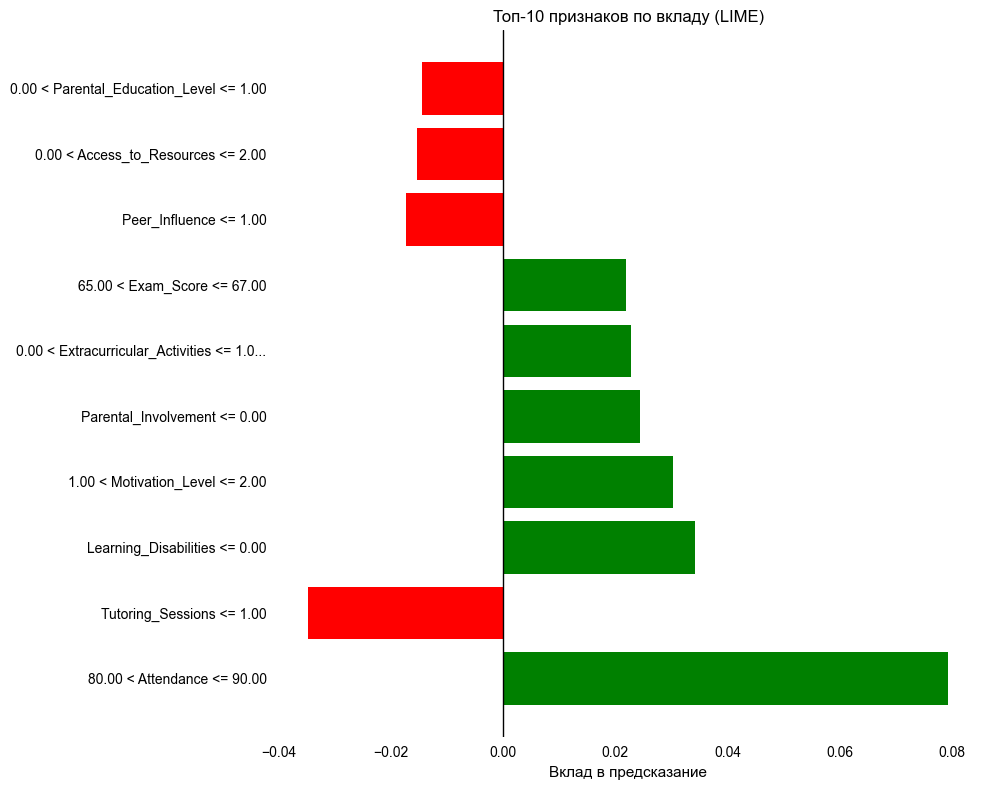


✅ LIME объяснитель готов к использованию в калькуляторе


In [ ]:
# LIME - Локальная интерпретация с красивой визуализацией
# LIME - Локальная интерпретация
if 'best_model' in globals() and best_model is not None:
    print("=" * 80)
    print("LIME - ЛОКАЛЬНАЯ ИНТЕРПРЕТАЦИЯ")
    print("=" * 80)
    
    import lime
    import lime.lime_tabular
    
    print("⏳ Создаем LIME объяснитель...")
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=class_names if 'class_names' in globals() else None,
        mode='classification',
        discretize_continuous=True
    )
    
    print("✅ LIME объяснитель создан")
    
    # Выбираем случайный пример из тестовой выборки
    idx = np.random.randint(0, len(X_test))
    instance = X_test.iloc[idx].values
    instance_df = X_test.iloc[idx:idx+1]
    
    # Предсказания
    prediction = best_model.predict(instance_df)[0]
    probabilities = best_model.predict_proba(instance_df)[0]
    true_class = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    
    print(f"\n📊 Анализируем пример #{idx} из тестовой выборки:")
    true_class_name = class_names[true_class] if 'class_names' in globals() and true_class < len(class_names) else f'Класс {true_class}'
    pred_class_name = class_names[prediction] if 'class_names' in globals() and prediction < len(class_names) else f'Класс {prediction}'
    print(f"   Реальный класс: {true_class} ({true_class_name})")
    print(f"   Предсказанный класс: {prediction} ({pred_class_name})")
    print(f"   Вероятности: {probabilities}")
    
    # Получаем объяснение
    print("\n⏳ Генерируем объяснение LIME...")
    explanation = explainer_lime.explain_instance(
        instance,
        best_model.predict_proba,
        num_features=min(15, len(X_train.columns))  # Топ-15 признаков
    )
    
    # Получаем данные из объяснения
    exp_list = explanation.as_list()
    
    # Создаем простую таблицу
    lime_df = pd.DataFrame({
        'Признак': [f[0] for f in exp_list],
        'Вклад': [f[1] for f in exp_list]
    }).sort_values('Вклад', key=abs, ascending=False)
    
    print("\n📋 Таблица вклада признаков (Топ-15):")
    print(lime_df.head(15).to_string(index=False))
    
    # Простой график
    plt.figure(figsize=(10, 8))
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    top_10 = lime_df.head(10)
    colors = ['green' if v > 0 else 'red' for v in top_10['Вклад']]
    plt.barh(range(len(top_10)), top_10['Вклад'], color=colors)
    plt.yticks(range(len(top_10)), [f[:40] + '...' if len(f) > 40 else f for f in top_10['Признак']])
    plt.xlabel('Вклад в предсказание', color='black')
    plt.title('Топ-10 признаков по вкладу (LIME)', color='black')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ LIME объяснитель готов к использованию в калькуляторе")
else:
    print("⚠️ Модель не обучена. Пожалуйста, выполните оптимизацию гиперпараметров.")

### 4.3. Глобальная интерпретация с SHAP


SHAP - ГЛОБАЛЬНАЯ ИНТЕРПРЕТАЦИЯ
⏳ Создаем SHAP объяснитель...
⏳ Вычисляем SHAP значения для 100 примеров...
✅ Бинарная классификация

📈 Сводная диаграмма важности признаков:


<Figure size 1200x800 with 0 Axes>

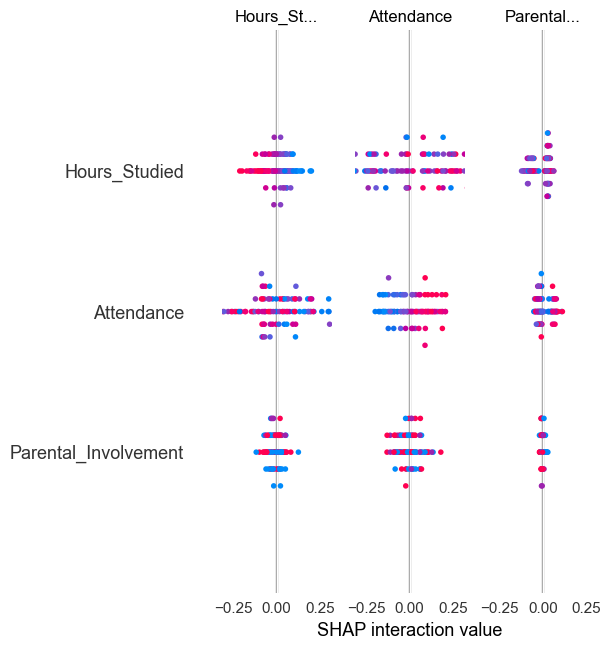


📋 Таблица важности признаков (Топ-20):
                   Признак  Средний |SHAP|
       Access_to_Resources        0.098391
Extracurricular_Activities        0.094025
             Hours_Studied        0.065658
                Attendance        0.063973
               Sleep_Hours        0.023990
          Motivation_Level        0.023141
           Internet_Access        0.018460
      Parental_Involvement        0.016143
             Family_Income        0.010610
           Teacher_Quality        0.008580
         Tutoring_Sessions        0.007828
                    Gender        0.007404
                Exam_Score        0.007307
  Parental_Education_Level        0.006676
        Distance_from_Home        0.006522
         Physical_Activity        0.005963
            Peer_Influence        0.005494
     Learning_Disabilities        0.005324
               School_Type        0.005215


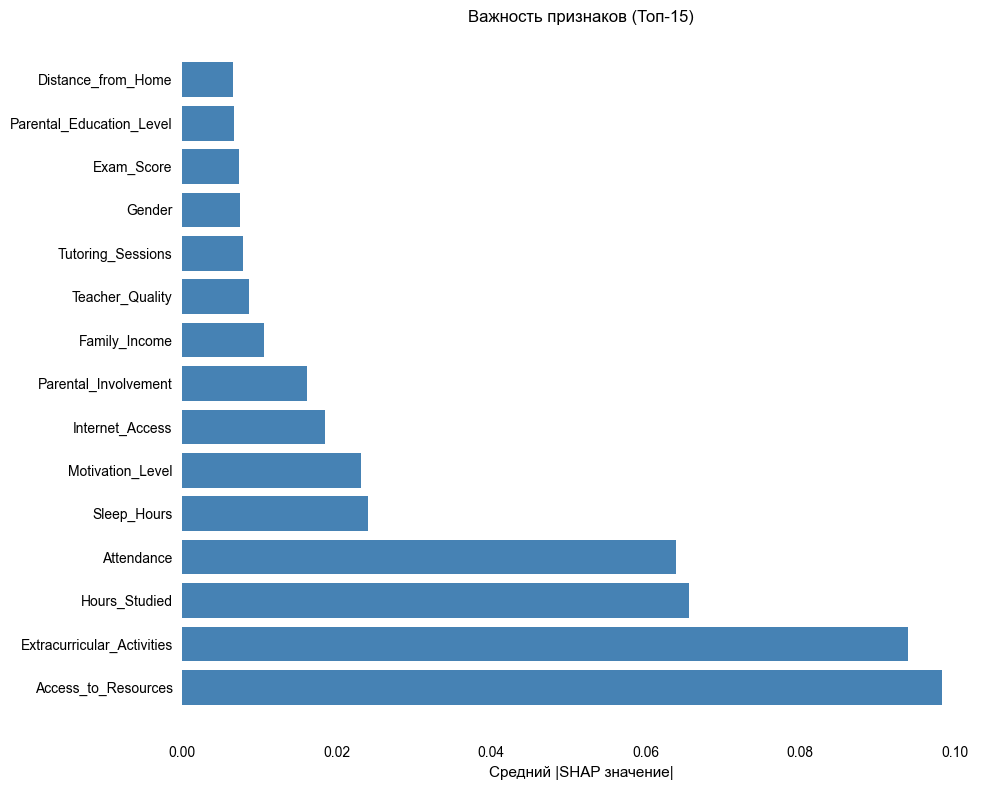


🏆 Топ-5 самых важных признаков:
   4. Access_to_Resources: 0.0984
   5. Extracurricular_Activities: 0.0940
   1. Hours_Studied: 0.0657
   2. Attendance: 0.0640
   6. Sleep_Hours: 0.0240

✅ SHAP объяснитель готов к использованию в калькуляторе


In [ ]:
# SHAP - Глобальная интерпретация
if 'best_model' in globals() and best_model is not None:
    print("=" * 80)
    print("SHAP - ГЛОБАЛЬНАЯ ИНТЕРПРЕТАЦИЯ")
    print("=" * 80)
    
    import shap
    
    print("⏳ Создаем SHAP объяснитель...")
    explainer_shap = shap.TreeExplainer(best_model)
    
    # Вычисляем SHAP значения для выборки (используем подвыборку для скорости)
    sample_size = min(100, len(X_test))
    X_test_sample = X_test.iloc[:sample_size]
    
    print(f"⏳ Вычисляем SHAP значения для {sample_size} примеров...")
    shap_values = explainer_shap.shap_values(X_test_sample)
    
    # Определяем, многоклассовая ли это классификация
    is_multiclass = isinstance(shap_values, list)
    
    if is_multiclass:
        print(f"✅ Многоклассовая классификация: {len(shap_values)} классов")
    else:
        print("✅ Бинарная классификация")
    
    # Summary plot
    print("\n📈 Сводная диаграмма важности признаков:")
    plt.figure(figsize=(12, 8))
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    if is_multiclass:
        shap.summary_plot(shap_values, X_test_sample, 
                         feature_names=X_test.columns.tolist(), 
                         class_names=class_names if 'class_names' in globals() else None, 
                         show=False)
    else:
        shap.summary_plot(shap_values, X_test_sample, 
                         feature_names=X_test.columns.tolist(), 
                         show=False)
    
    plt.tight_layout()
    plt.show()
    
    # Вычисляем средние абсолютные SHAP значения
    if is_multiclass:
        mean_abs_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    else:
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    mean_abs_shap = np.array(mean_abs_shap).flatten()
    n_features = len(X_test.columns)
    if len(mean_abs_shap) != n_features:
        mean_abs_shap = mean_abs_shap[:n_features]
    
    # Простая таблица
    feature_importance_df = pd.DataFrame({
        'Признак': X_test.columns.tolist(),
        'Средний |SHAP|': mean_abs_shap
    }).sort_values('Средний |SHAP|', ascending=False)
    
    print("\n📋 Таблица важности признаков (Топ-20):")
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Простой график
    plt.figure(figsize=(10, 8))
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    top_15 = feature_importance_df.head(15)
    plt.barh(range(len(top_15)), top_15['Средний |SHAP|'], color='steelblue')
    plt.yticks(range(len(top_15)), [f[:40] + '...' if len(f) > 40 else f for f in top_15['Признак']])
    plt.xlabel('Средний |SHAP значение|', color='black')
    plt.title('Важность признаков (Топ-15)', color='black')
    plt.tight_layout()
    plt.show()
    
    # Топ-5 признаков
    print("\n🏆 Топ-5 самых важных признаков:")
    top_5 = feature_importance_df.head(5)
    for i, row in top_5.iterrows():
        print(f"   {i+1}. {row['Признак']}: {row['Средний |SHAP|']:.4f}")
    
    print(f"\n✅ SHAP объяснитель готов к использованию в калькуляторе")
else:
    print("⚠️ Модель не обучена. Пожалуйста, выполните оптимизацию гиперпараметров.")

### 4.4. Интерактивный калькулятор

Создадим функцию-калькулятор, которая принимает входные данные и показывает интерпретацию.


In [ ]:
def prediction_calculator(model, explainer_lime, explainer_shap, X_train, feature_names, 
                          input_data, class_names=None):
    """
    Калькулятор для предсказания и интерпретации
    
    Parameters:
    -----------
    model : обученная модель
    explainer_lime : LIME объяснитель
    explainer_shap : SHAP объяснитель
    X_train : обучающие данные (для проверки формата)
    feature_names : названия признаков
    input_data : словарь или DataFrame с входными данными
    class_names : названия классов (опционально)
    """
    # Преобразуем входные данные в DataFrame
    if isinstance(input_data, dict):
        # Создаем DataFrame с правильным порядком признаков
        input_df = pd.DataFrame([input_data])
        # Убеждаемся, что порядок колонок соответствует X_train
        if hasattr(X_train, 'columns'):
            input_df = input_df.reindex(columns=X_train.columns, fill_value=0)
    else:
        input_df = input_data.copy()
    
    # Предсказание
    prediction = model.predict(input_df)[0]
    prediction_proba = model.predict_proba(input_df)[0]
    
    print("=" * 80)
    print("РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ")
    print("=" * 80)
    print(f"🎯 Предсказанный класс: {prediction}")
    if class_names and prediction < len(class_names):
        print(f"📝 Класс: {class_names[prediction]}")
    print(f"\n📊 Вероятности:")
    for i, prob in enumerate(prediction_proba):
        class_label = class_names[i] if class_names and i < len(class_names) else f"Класс {i}"
        print(f"   {class_label}: {prob:.4f} ({prob*100:.2f}%)")
    
    # LIME интерпретация
    print("\n" + "=" * 80)
    print("ЛОКАЛЬНАЯ ИНТЕРПРЕТАЦИЯ (LIME)")
    print("=" * 80)
    
    instance = input_df.iloc[0].values
    explanation = explainer_lime.explain_instance(
        instance,
        model.predict_proba,
        num_features=min(10, len(feature_names))
    )
    
    exp_list = explanation.as_list()
    lime_df = pd.DataFrame({
        'Признак': [f[0] for f in exp_list],
        'Вклад': [f[1] for f in exp_list]
    }).sort_values('Вклад', key=abs, ascending=False)
    
    print("\nТоп-10 признаков по вкладу:")
    print(lime_df.head(10).to_string(index=False))
    
    # Простой график LIME
    plt.figure(figsize=(8, 6))
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    top_10 = lime_df.head(10)
    colors = ['green' if v > 0 else 'red' for v in top_10['Вклад']]
    plt.barh(range(len(top_10)), top_10['Вклад'], color=colors)
    plt.yticks(range(len(top_10)), [f[:35] + '...' if len(f) > 35 else f for f in top_10['Признак']])
    plt.xlabel('Вклад в предсказание', color='black')
    plt.title('Топ-10 признаков (LIME)', color='black')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    # SHAP интерпретация для этого примера
    print("\n" + "=" * 80)
    print("ГЛОБАЛЬНАЯ ИНТЕРПРЕТАЦИЯ (SHAP) - для данного примера")
    print("=" * 80)
    
    try:
        shap_values_instance = explainer_shap.shap_values(input_df)
        is_multiclass = isinstance(shap_values_instance, list)
        
        if is_multiclass:
            shap_vals = shap_values_instance[prediction][0]
        else:
            shap_vals = shap_values_instance[0]
        
        shap_vals = np.array(shap_vals).flatten()
        if len(shap_vals) != len(feature_names):
            shap_vals = shap_vals[:len(feature_names)]
        
        shap_df = pd.DataFrame({
            'Признак': feature_names,
            'SHAP значение': shap_vals
        }).sort_values('SHAP значение', key=abs, ascending=False)
        
        print("\nТоп-10 признаков по влиянию на предсказание:")
        print(shap_df.head(10).to_string(index=False))
        
    except Exception as e:
        print(f"⚠️ Ошибка при создании SHAP интерпретации: {e}")
    
    return prediction, prediction_proba, explanation

print("✅ Функция-калькулятор создана")
print("\n📝 Использование:")
print("   prediction_calculator(best_model, explainer_lime, explainer_shap, X_train, X_train.columns, new_data, class_names)")

✅ Функция-калькулятор создана

📝 Использование:
   prediction_calculator(best_model, explainer_lime, explainer_shap, X_train, X_train.columns, new_data, class_names)


### 4.5. Пример использования калькулятора


ПРИМЕР ИСПОЛЬЗОВАНИЯ КАЛЬКУЛЯТОРА

📊 Анализируем пример студента #895 из тестовой выборки:
   Реальный класс: 2 (Высокая успеваемость)

📋 Некоторые значения признаков:
   Hours_Studied: 14
   Attendance: 77
   Exam_Score: 89

ЗАПУСК КАЛЬКУЛЯТОРА...
РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ
🎯 Предсказанный класс: 1
📝 Класс: Средняя успеваемость

📊 Вероятности:
   Низкая успеваемость: 0.2512 (25.12%)
   Средняя успеваемость: 0.6555 (65.55%)
   Высокая успеваемость: 0.0933 (9.33%)

ЛОКАЛЬНАЯ ИНТЕРПРЕТАЦИЯ (LIME)

Топ-10 признаков по вкладу:
                            Признак     Вклад
                 Exam_Score > 69.00 -0.238453
             Hours_Studied <= 16.00 -0.100608
        70.00 < Attendance <= 80.00 -0.052770
          Tutoring_Sessions <= 1.00 -0.029205
   3.00 < Physical_Activity <= 4.00  0.019943
  1.00 < Distance_from_Home <= 2.00  0.019807
0.00 < Parental_Involvement <= 2.00 -0.017269
       Learning_Disabilities > 0.00 -0.015816
        Access_to_Resources <= 0.00  0.015561
             P

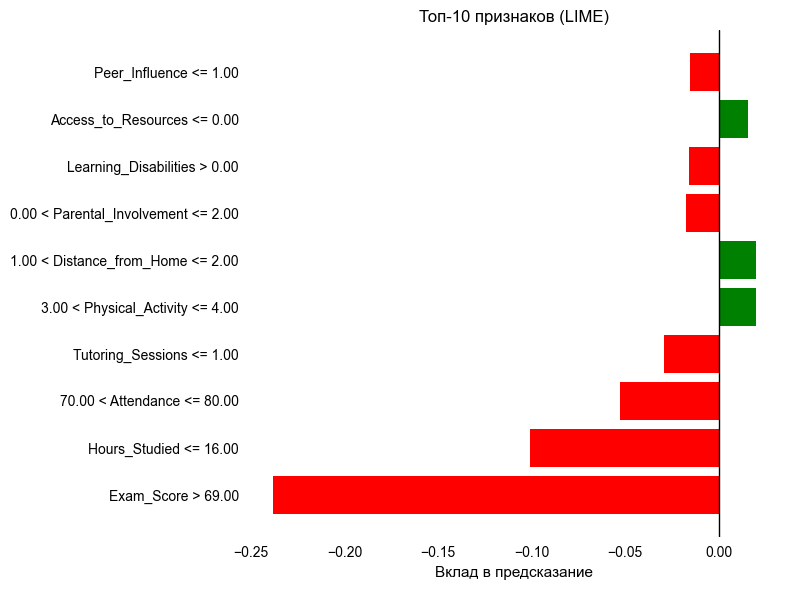


ГЛОБАЛЬНАЯ ИНТЕРПРЕТАЦИЯ (SHAP) - для данного примера

Топ-10 признаков по влиянию на предсказание:
                   Признак  SHAP значение
Extracurricular_Activities       0.160937
       Access_to_Resources      -0.098223
               Sleep_Hours      -0.062714
                Attendance      -0.025706
             Hours_Studied       0.023626
          Motivation_Level       0.015656
            Peer_Influence       0.009991
         Tutoring_Sessions      -0.009635
        Distance_from_Home      -0.007968
             Family_Income      -0.006714

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Реальный класс: 2 (Высокая успеваемость)
Предсказанный класс: 1 (Средняя успеваемость)
❌ Предсказание неверное
   Разница: 0.5621

✅ Калькулятор успешно протестирован!

💡 Вы можете использовать калькулятор для анализа любых данных:
   prediction_calculator(best_model, explainer_lime, explainer_shap, X_train, X_train.columns, ваши_данные, class_names)

📝 Пример для нового студента:
   new_student = {
       'Hou

In [20]:
# ПРИМЕР ИСПОЛЬЗОВАНИЯ КАЛЬКУЛЯТОРА
if 'best_model' in globals() and 'explainer_lime' in globals() and 'explainer_shap' in globals():
    print("=" * 80)
    print("ПРИМЕР ИСПОЛЬЗОВАНИЯ КАЛЬКУЛЯТОРА")
    print("=" * 80)
    
    # Берем случайный пример из тестовой выборки
    example_idx = np.random.randint(0, len(X_test))
    example_data = X_test.iloc[example_idx:example_idx+1]
    
    print(f"\n📊 Анализируем пример студента #{example_idx} из тестовой выборки:")
    
    # Получаем реальный класс
    if hasattr(y_test, 'iloc'):
        true_class = y_test.iloc[example_idx]
    else:
        true_class = y_test[example_idx]
    
    true_class_name = class_names[true_class] if 'class_names' in globals() and true_class < len(class_names) else f'Класс {true_class}'
    print(f"   Реальный класс: {true_class} ({true_class_name})")
    
    # Показываем некоторые ключевые значения признаков
    print(f"\n📋 Некоторые значения признаков:")
    key_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score']
    for feat in key_features:
        if feat in example_data.columns:
            print(f"   {feat}: {example_data[feat].values[0]}")
    
    print("\n" + "=" * 80)
    print("ЗАПУСК КАЛЬКУЛЯТОРА...")
    print("=" * 80)
    
    # Используем калькулятор
    pred, proba, expl = prediction_calculator(
        best_model, 
        explainer_lime, 
        explainer_shap, 
        X_train, 
        X_train.columns.tolist(),
        example_data,
        class_names
    )
    
    # Сравниваем предсказание с реальным классом
    print("\n" + "=" * 80)
    print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
    print("=" * 80)
    print(f"Реальный класс: {true_class} ({true_class_name})")
    pred_class_name = class_names[pred] if 'class_names' in globals() and pred < len(class_names) else f'Класс {pred}'
    print(f"Предсказанный класс: {pred} ({pred_class_name})")
    
    if true_class == pred:
        print("✅ Предсказание правильное!")
    else:
        print("❌ Предсказание неверное")
        print(f"   Разница: {abs(proba[true_class] - proba[pred]):.4f}")
    
    print("\n✅ Калькулятор успешно протестирован!")
    print("\n💡 Вы можете использовать калькулятор для анализа любых данных:")
    print("   prediction_calculator(best_model, explainer_lime, explainer_shap, X_train, X_train.columns, ваши_данные, class_names)")
    print("\n📝 Пример для нового студента:")
    print("   new_student = {")
    print("       'Hours_Studied': 25,")
    print("       'Attendance': 90,")
    print("       'Previous_Scores': 85,")
    print("       # ... остальные признаки")
    print("   }")
    print("   prediction_calculator(best_model, explainer_lime, explainer_shap, X_train, X_train.columns, new_student, class_names)")
else:
    print("⚠️ Не все компоненты готовы. Убедитесь, что выполнены все предыдущие ячейки.")
    print("   Необходимо:")
    print("   - best_model (лучшая модель)")
    print("   - explainer_lime (LIME объяснитель)")
    print("   - explainer_shap (SHAP объяснитель)")

## Заключение

В данной лабораторной работе:
1. ✅ Выбрана модель **Random Forest** для классификации успеваемости студентов
2. ✅ Представлена таблица гиперпараметров модели
3. ✅ Подготовлен датасет "Факторы успеваемости студентов"
4. ✅ Реализованы три метода подбора гиперпараметров:
   - **Grid Search** - полный перебор комбинаций
   - **Random Search** - случайный поиск
   - **Optuna** - байесовская оптимизация
5. ✅ Сравнены результаты методов по точности и времени выполнения
6. ✅ Создан калькулятор с **LIME** (локальная интерпретация) и **SHAP** (глобальная интерпретация)

### Выводы:

**Сравнение методов подбора гиперпараметров:**
- **Grid Search**: Точный, но медленный. Перебирает все комбинации.
- **Random Search**: Быстрее Grid Search, но может пропустить оптимальные параметры.
- **Optuna**: Эффективный баланс между точностью и скоростью благодаря байесовской оптимизации.

**Интерпретация модели:**
- **LIME** позволяет понять, какие признаки важны для конкретного предсказания (локальная интерпретация).
- **SHAP** показывает общую важность признаков для модели (глобальная интерпретация).

**Практическое применение:**
Калькулятор позволяет анализировать факторы успеваемости для конкретного студента и получать объяснения предсказаний модели.
